In [1]:
import os 
import sys
import time

paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

In [2]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import numpy as np
import scipy.stats
from jax import random
import matplotlib.pyplot as plt

from fbpinns import networks
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer


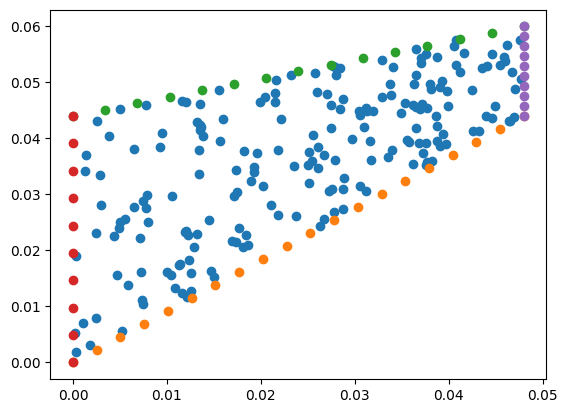

In [3]:
# step 1
from fbpinns.domains import Domain

class CooksDomainND(Domain):
    @staticmethod
    def init_params(corners):
        xd = corners.shape[1]
        static_params = {
            "xd" : xd,
            "corners" : jnp.array(corners)
        }
        return static_params, {}
    @staticmethod
    def phi(xi, eta):
        phiA = 0.25 * (1 - xi) * (1 - eta)
        phiB = 0.25 * (1 + xi) * (1 - eta)
        phiC = 0.25 * (1 + xi) * (1 + eta)
        phiD = 0.25 * (1 - xi) * (1 + eta)
        return jnp.array([phiA, phiB, phiC, phiD])
    @staticmethod
    def transformation_matrix(xi, eta, x_hat):
        phi_values = CooksDomainND.phi(xi, eta)
        
        t_mat = jnp.zeros((2, 8))
        t_mat = t_mat.at[0, :4].set(phi_values)
        t_mat = t_mat.at[1, 4:].set(phi_values)
        transformed = jnp.dot(t_mat, x_hat)
        return transformed
    
    @staticmethod
    def _rectangle_samplerND(key, sampler, xmin, xmax, batch_shape):
        "Get flattened samples of x in a rectangle, either on mesh or random"

        assert xmin.shape == xmax.shape
        assert xmin.ndim == 1
        xd = len(xmin)
        assert len(batch_shape) == xd

        if not sampler in ["grid", "uniform", "sobol", "halton"]:
            raise ValueError("ERROR: unexpected sampler")

        if sampler == "grid":
            xs = [jnp.linspace(xmin, xmax, b) for xmin,xmax,b in zip(xmin, xmax, batch_shape)]
            xx = jnp.stack(jnp.meshgrid(*xs, indexing="ij"), -1)# (batch_shape, xd)
            x_batch = xx.reshape((-1, xd))
        else:
            if sampler == "halton":
                # use scipy as not implemented in jax (!)
                r = scipy.stats.qmc.Halton(xd)
                s = r.random(np.prod(batch_shape))
            elif sampler == "sobol":
                r = scipy.stats.qmc.Sobol(xd)
                s = r.random(np.prod(batch_shape))
            elif sampler == "uniform":
                s = jax.random.uniform(key, (np.prod(batch_shape), xd))

            xmin, xmax = xmin.reshape((1,-1)), xmax.reshape((1,-1))
            x_batch = xmin + (xmax - xmin)*s

        return jnp.array(x_batch)
    
    @staticmethod
    def sample_interior(all_params, key, sampler, batch_shape):
        # xd = all_params["static"]["domain"]["xd"]
        corners = all_params["static"]["domain"]["corners"]
        x_hat = jnp.concatenate([corners[:, 0], corners[:, 1]])
        # isoparametric element
        xmin, xmax = jnp.array([-1,-1]), jnp.array([1,1])
        x_batch_iso =  CooksDomainND._rectangle_samplerND(key, sampler, xmin, xmax, batch_shape)
        return vmap(CooksDomainND.transformation_matrix, in_axes=(0, 0, None))(x_batch_iso[:, 0], x_batch_iso[:, 1], x_hat)
    
    @staticmethod
    def sample_boundaries(all_params, key, sampler, batch_shapes):
        xmin, xmax = jnp.array([-1,-1]), jnp.array([1,1]) #isoparametric_elememnt

        xd = all_params["static"]["domain"]["xd"]
        corners = all_params["static"]["domain"]["corners"]
        x_hat = jnp.concatenate([corners[:, 0], corners[:, 1]])

        assert len(batch_shapes) == 2*xd# total number of boundaries

        x_batches = []
        for i in range(xd):
            ic = jnp.array(list(range(i))+list(range(i+1,xd)), dtype=int)
            for j,v in enumerate([xmin[i], xmax[i]]):
                batch_shape = batch_shapes[2*i+j]
                if len(ic):
                    xmin_, xmax_ = xmin[ic], xmax[ic]
                    key, subkey = jax.random.split(key)
                    x_batch_ = CooksDomainND._rectangle_samplerND(subkey, sampler, xmin_, xmax_, batch_shape)# (n, xd-1)
                    x_batch = v*jnp.ones((jnp.prod(jnp.array(batch_shape)),xd), dtype=float)
                    x_batch = x_batch.at[:,ic].set(x_batch_)
                else:
                    assert len(batch_shape) == 1
                    x_batch = v*jnp.ones(batch_shape+(1,), dtype=float)
                x_batch = vmap(CooksDomainND.transformation_matrix, in_axes=(0, 0, None))(x_batch[:, 0], x_batch[:, 1], x_hat)
                x_batches.append(x_batch)
        return x_batches
    
    #TODO check norm_fn with Alexander
    @staticmethod 
    def norm_fn(all_params, x):
        xmin, xmax = jnp.array([-1.,-1.]), jnp.array([1.,1,])
        #xmin, xmax = jnp.array([0.,0.]), jnp.array([0.048,0.06]) #isoparametric_elememnt
        # xmin, xmax = all_params["static"]["domain"]["xmin"], all_params["static"]["domain"]["xmax"]
        x_hat = jnp.concatenate([corners[:, 0], corners[:, 1]])
        mu, sd = (xmax+xmin)/2, (xmax-xmin)/2
        x = networks.norm(mu, sd, x)
        return x

# corner(left_bottom, left_top, right_top, right_bottom)
corners = jnp.array([(0., 0.), (0, 0.044), (0.048, 0.060), (0.048, 0.044)]) 
domain = CooksDomainND
domain_init_kwargs = dict(
    corners=corners,
)


# Example 2D Plot
key = jax.random.PRNGKey(0)
all_params = {
    "static": {
        "domain": {
            "xd": 2,
            "corners": corners,
        }
    }
}

batch_shape = (10,20)  # for example
x_batch = domain.sample_interior(all_params, key, 'uniform', batch_shape)

batch_shapes = ((20,),(15,),(10,),(10,)) # bottom, top, left, right
x_boundaries = domain.sample_boundaries(all_params, key, 'grid', batch_shapes)

plt.scatter(x_batch[:, 0:1], x_batch[:, 1:2])
for x_batch_b in x_boundaries:
        plt.scatter(x_batch_b[:,0], x_batch_b[:,1], )

In [4]:
# step 2

""" 
julia code: 
function calculate_E(x)
    λ = x.λ
    μ = x.μ
    δ(i,j) = i == j ? 1.0 : 0.0
    EE = SymmetricTensor{4, 2}(
        (i,j,k,l) -> λ * δ(i,j) * δ(k,l) + μ * (δ(i,k) * δ(j,l) + δ(i,l) * δ(j,k))
    )    
    return EE;
end
"""
import jax.numpy as jnp
from fbpinns.problems import Problem

class CooksProblemForward(Problem):
    """ Linear Elasticity, plain strain, DBC at left, NBC at right"""
    @staticmethod
    def init_params(lambda_true= 4, mu_true = 5, nbc_points_right = 10, nbc_points_top=10, nbc_points_bottom=10, sd=0.1):
        E = lambda_true * jnp.einsum("ij, kl->ijkl", jnp.eye(2), jnp.eye(2)) + mu_true *(
                jnp.einsum("ik, jl->ijkl", jnp.eye(2), jnp.eye(2)) + jnp.einsum("il, jk->ijkl", jnp.eye(2), jnp.eye(2))
            )
        static_params = {
            "dims":(5,2), # Out: ux, uy,sigma_xx, sigma_yy, sigma_xy[symmetric], in: (x,y)
            "E":E,
            "nbc_points_right":nbc_points_right,
            "nbc_points_top":nbc_points_top,
            "nbc_points_bottom":nbc_points_bottom,
            "sd":sd
        }
        return static_params, {}
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Physics Loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (   # we need: ux,x; uy,y; ux,y; uy,x; sigma_xx,x; sigma_yy,y; sigma_xy,x; sigma_xy,y
            (0, (0,)),      # ux,x (out_idx, (in_idx, in_idx))
            (1, (1,)),      # uy,y
            (0, (1,)),      # ux, y
            (1, (0,)),      # uy, x
            (2, (0,)),      # sigma_xx,x
            (3, (1,)),      # sigma_yy,y;
            (4, (0,)),      # sigma_xy,x; 
            (4, (1,)),      # sigma_xy,y
            (2,()),         # stress_xx
            (3,()),         # stress_yy
            (4,()),         # stress_xy or stress_yx
        )
        nbc_points_right = all_params["static"]["problem"]["nbc_points_right"]
        nbc_points_top = all_params["static"]["problem"]["nbc_points_top"]
        nbc_points_bottom = all_params["static"]["problem"]["nbc_points_bottom"]
        batch_shapes = ((nbc_points_bottom,),(nbc_points_top,),(0,),(nbc_points_right,)) # bottom, top, left, right
        x_batch_neumann_bottom, x_batch_neumann_top, _,x_batch_neumann_right = domain.sample_boundaries(all_params, key, sampler, batch_shapes)
        required_ujs_neumann_right = (
            (2, ()),      # sigma_xx,
            (3, ()),      # sigma_yy
            (4, ()),      # sigma_xy
        )

        required_ujs_neumann_top = (
            (2, ()),      # sigma_xx,
            (3, ()),      # sigma_yy
            (4, ()),      # sigma_xy
        )

        required_ujs_neumann_bottom = (
            (2, ()),      # sigma_xx,
            (3, ()),      # sigma_yy
            (4, ()),      # sigma_xy
        )

        return [[x_batch_phys, required_ujs_phys],
                [x_batch_neumann_right, required_ujs_neumann_right],
                [x_batch_neumann_top, required_ujs_neumann_top],
                [x_batch_neumann_bottom, required_ujs_neumann_bottom]]

    @staticmethod
    def constraining_fn(all_params, x_batch, solution):
        sd = all_params["static"]["problem"]["sd"]

        x, tanh = x_batch[:,0:1], jnp.tanh

        u = solution[:, 0:1] * tanh(x/sd)  # Hard constraining
        v = solution[:, 1:2] * tanh(x/sd) 

        return jnp.concatenate([u, v, solution[:, 2:3], solution[:, 3:4], solution[:, 4:5]], axis=1)
    
    @staticmethod
    def shape_symmetric_gradient(ux, uy, vx, vy):
        return jnp.array([[ux, 0.5*uy*vx], [0.5*uy*vx, vy]])
    
    @staticmethod
    def batched_shape_symmetric_gradient(ux_x, uy_y, ux_y, uy_x):

        # Flatten
        ux_x_flat = ux_x.ravel()
        uy_y_flat = uy_y.ravel()
        ux_y_flat = ux_y.ravel()
        uy_x_flat = uy_x.ravel()

        # Vectorize
        v_shape_symmetric_gradient = vmap(CooksProblemForward.shape_symmetric_gradient, in_axes=(0, 0, 0, 0), out_axes=0)

        # Apply the vectorized function 
        epsilon_batch = v_shape_symmetric_gradient(ux_x_flat, uy_y_flat, ux_y_flat, uy_x_flat)

        return epsilon_batch

    @staticmethod
    def loss_fn(all_params, constraints):
        E = all_params["static"]["problem"]["E"]
        _, ux_x, uy_y, ux_y, uy_x, sigmaxx_x, sigmayy_y, sigmaxy_x, sigmaxy_y, stressxx, stressyy, stressxy= constraints[0]
        # Material Model
        epsilon_batch = CooksProblemForward.batched_shape_symmetric_gradient(ux_x, uy_y, ux_y, uy_x)
        stress_batch = jnp.einsum("ijkl, akl->aij", E, epsilon_batch)
        MM_loss = (jnp.mean((stressxx - stress_batch[:, 0, 0])**2) + # sigmaxx - sigmaxx (E \boxdot epsilon)
                        jnp.mean((stressyy - stress_batch[:, 1, 1])**2) + # sigmayy - sigmayy (E \boxdot epsilon)
                        jnp.mean((stressxy - stress_batch[:, 0, 1])**2)) # sigmaxy - sigmaxy (E \boxdot epsilon). stress_batch[:, 1, 0] == stress_batch[:, 0, 1] [symmetric stress]
        # Balance
        Balance_loss =  jnp.mean((sigmaxx_x + sigmaxy_y)**2) + jnp.mean((sigmayy_y + sigmaxy_x)**2)
        phy_loss = MM_loss + Balance_loss

        # Neumann Boundary condition [dirichlet handeled in the hard constraints] See: constraining_fn()
        # nbc right
        _, sigmaxx_n, sigmayy_n, sigmaxy_n = constraints[1]
        unit_normal_vec_right = jnp.array([1.,0.])                      # unit normal (1,0)
        applied_traction_right = jnp.array([0.,1.])
        nbc_loss_right = (jnp.mean((sigmaxx_n*unit_normal_vec_right[0] + sigmaxy_n*unit_normal_vec_right[1] - applied_traction_right[0])**2) +
                    jnp.mean((sigmaxy_n*unit_normal_vec_right[0] + sigmayy_n*unit_normal_vec_right[1] - applied_traction_right[1])**2))
        
        # nbc top
        _, sigmaxx_n, sigmayy_n, sigmaxy_n = constraints[2]
        unit_normal_vec_top = jnp.array([-0.3162279,  0.9486832])        # unit normal (-0.3162279,  0.9486832) 
        applied_traction_top = jnp.array([0.,0.])
        nbc_loss_top = (jnp.mean((sigmaxx_n*unit_normal_vec_top[0] + sigmaxy_n*unit_normal_vec_top[1] - applied_traction_top[0])**2) +
                    jnp.mean((sigmaxy_n*unit_normal_vec_top[0] + sigmayy_n*unit_normal_vec_top[1] - applied_traction_top[1])**2))
        
        # nbc bottom
        _, sigmaxx_n, sigmayy_n, sigmaxy_n = constraints[3]
        unit_normal_vec_bottom = jnp.array([ 0.67572457, -0.7371541])    # unit normal (0.67572457, -0.7371541)  

        applied_traction_bottom = jnp.array([0.,0.])
        nbc_loss_bottom = (jnp.mean((sigmaxx_n*unit_normal_vec_bottom[0] + sigmaxy_n*unit_normal_vec_bottom[1] - applied_traction_bottom[0])**2) +
                    jnp.mean((sigmaxy_n*unit_normal_vec_bottom[0] + sigmayy_n*unit_normal_vec_bottom[1] - applied_traction_bottom[1])**2))
        
        return 1e6*phy_loss + 1e6*nbc_loss_right + 1e6*nbc_loss_top + 1e6*nbc_loss_bottom
    
    @staticmethod 
    def exact_solution(all_params, x_batch, batch_shape=None):
        noise_scale = 1e-6
        key = jax.random.PRNGKey(0) 

        noise = noise_scale * jax.random.normal(key, (x_batch.shape[0],all_params["static"]["problem"]["dims"][0]))
        
        return noise

problem = CooksProblemForward
problem_init_kwargs = dict(
    lambda_true= 4, mu_true = 5, nbc_points_right = 150, nbc_points_top=150, nbc_points_bottom=150, sd=0.1,
)

{'subdomain_xs': [array([0.   , 0.048]), array([0.  , 0.06])], 'subdomain_ws': [array([0.0576, 0.0576]), array([0.072, 0.072])], 'unnorm': (0.0, 3.0)}


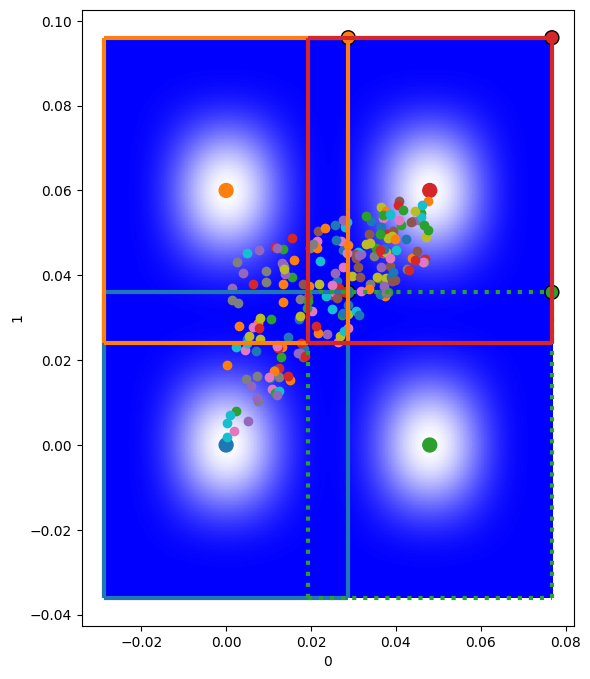

In [5]:
decomposition = RectangularDecompositionND
wo = 1.2
subdomain_xs = [np.linspace(0,0.048,2), np.linspace(0,0.060,2)]
subdomain_ws=get_subdomain_ws(subdomain_xs, wo)
decomposition_init_kwargs = dict(
    subdomain_xs=subdomain_xs,
    subdomain_ws=get_subdomain_ws(subdomain_xs, wo),
    unnorm=(0.,3.),
)
print(decomposition_init_kwargs)

# plot 2D
ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,3))
all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}
m = all_params["static"]["decomposition"]["m"]
active = np.ones(m)

# active[1] = 0
active[2] = 2
decomposition.plot(all_params, active=active, show_norm=True, show_window=True)

for x in x_batch:
    plt.scatter(x[0], x[1])
plt.show()
# print(decomposition.inside_models(all_params, x_batch, np.arange(m)))
# print(decomposition.inside_points(all_params, x_batch))


In [6]:
network=FCN
network_init_kwargs = dict(
    layer_sizes = (2, 16, 5),
)

In [7]:
scheduler = LineSchedulerRectangularND
scheduler_kwargs = dict(
    point=[0.], iaxis=0,
)


In [8]:
tag = "CooksMembrane"
nc = (50,40)
epochs = 20000
h = len(network_init_kwargs["layer_sizes"]) - 2
p = sum(network_init_kwargs["layer_sizes"][1:-1])
run = f"FBPINN_{tag}_{problem.__name__}_{network.__name__}_{nc}-nCol_{epochs}-epochs_{h}-layers_{p}-hidden_{wo}_wo_"
run

'FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_'

In [9]:
from fbpinns.constants import Constants

c = Constants(
    run=run,
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    ns=(nc,),# use 200 collocation points for training
    n_test=(50,50),# use 500 points for testing
    n_steps=epochs,# number of training steps
    clear_output=True,
    show_figures=False,
    test_freq=100000,
    skip_plot_at_first=True,
)
print(c)

run: FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_
domain: <class '__main__.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class '__main__.CooksProblemForward'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 150, 'nbc_points_top': 150, 'nbc_points_bottom': 150, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.   , 0.048]), array([0.  , 0.06])], 'subdomain_ws': [array([0.0576, 0.0576]), array([0.072, 0.072])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': (2, 16, 5)}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.LineSchedulerRectangularND'>
scheduler_kwargs: {'point': [0.0], 'iaxis': 0}
ns: ((50, 40),)
n_test: (50, 50)
sampler: grid
optimiser

In [10]:
training_time = time.time()
FBPINNrun = FBPINNTrainer(c)
FBPINNrun.train()

training_time = time.time() - training_time

[INFO] 2024-03-25 20:45:21 - <fbpinns.constants.Constants object at 0x000001C89CEF83B0>
run: FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_
domain: <class '__main__.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class '__main__.CooksProblemForward'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 150, 'nbc_points_top': 150, 'nbc_points_bottom': 150, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.   , 0.048]), array([0.  , 0.06])], 'subdomain_ws': [array([0.0576, 0.0576]), array([0.072, 0.072])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': (2, 16, 5)}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.LineSchedulerRectangularND'>
scheduler_kwarg

NaN or Inf found in input tensor.


[INFO] 2024-03-25 20:45:40 - [i: 2000/20000] loss: nan rate: 217.7 elapsed: 0.00 hr FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_


NaN or Inf found in input tensor.


[INFO] 2024-03-25 20:45:44 - [i: 3000/20000] loss: nan rate: 216.2 elapsed: 0.01 hr FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_


NaN or Inf found in input tensor.


[INFO] 2024-03-25 20:45:49 - [i: 4000/20000] loss: nan rate: 213.2 elapsed: 0.01 hr FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_


NaN or Inf found in input tensor.


[INFO] 2024-03-25 20:45:54 - [i: 5000/20000] loss: nan rate: 217.7 elapsed: 0.01 hr FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_


NaN or Inf found in input tensor.


[INFO] 2024-03-25 20:45:58 - [i: 6000/20000] loss: nan rate: 226.7 elapsed: 0.01 hr FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_


NaN or Inf found in input tensor.


[INFO] 2024-03-25 20:46:01 - [i: 6667/20000] Updating active inputs..
[INFO] 2024-03-25 20:46:01 - [i: 6667/20000] Average number of points/dimension in active subdomains: 34.81
[INFO] 2024-03-25 20:46:03 - [i: 6667/20000] Updating active inputs done (2.36 s)
[INFO] 2024-03-25 20:46:03 - [i: 6667/20000] Compiling update step..
[INFO] 2024-03-25 20:46:03 - x_batch
[INFO] 2024-03-25 20:46:03 - (1650, 2), float32, JVPTracer
[INFO] 2024-03-25 20:46:03 - x_take
[INFO] 2024-03-25 20:46:03 - (2652, 2), float32, JVPTracer
[INFO] 2024-03-25 20:46:04 - x_batch
[INFO] 2024-03-25 20:46:04 - (1650, 2), float32, JVPTracer
[INFO] 2024-03-25 20:46:04 - x_take
[INFO] 2024-03-25 20:46:04 - (2652, 2), float32, JVPTracer
[INFO] 2024-03-25 20:46:04 - x_batch
[INFO] 2024-03-25 20:46:04 - (150, 2), float32, DynamicJaxprTracer
[INFO] 2024-03-25 20:46:04 - x_take
[INFO] 2024-03-25 20:46:04 - (150, 2), float32, DynamicJaxprTracer
[INFO] 2024-03-25 20:46:04 - x_batch
[INFO] 2024-03-25 20:46:04 - (150, 2), float3

In [12]:
from FBPINNsModel.plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

# run = "test"
c, model = load_model(run, rootdir="results/")

[INFO] 2024-03-25 20:49:40 - Loading model from:
results/models/FBPINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_/model_00020000.jax


In [13]:
from fbpinns.analysis import FBPINN_solution, PINN_solution
i, all_params, all_opt_states, active, u_test_losses = model
x_batch = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(500,500))
out = FBPINN_solution(c, all_params, active, x_batch)

[INFO] 2024-03-25 20:49:42 - x_batch
[INFO] 2024-03-25 20:49:42 - (250000, 2), float32, ArrayImpl
[INFO] 2024-03-25 20:49:42 - x_take
[INFO] 2024-03-25 20:49:42 - (380711, 2), float32, ArrayImpl


In [14]:
ux, uy, sigaxx, sigmayy, sigmaxy  = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4],out[:,4:5]

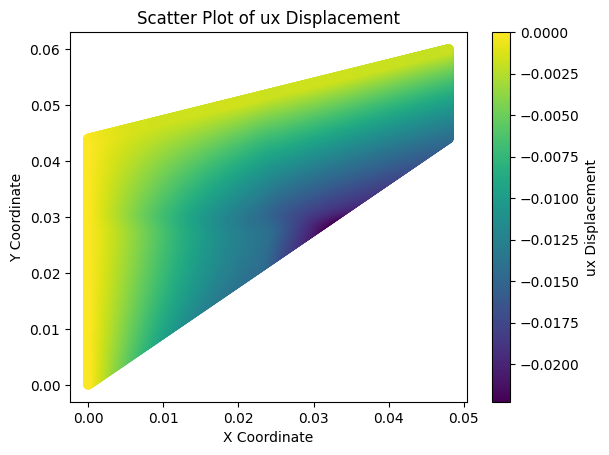

In [16]:
import matplotlib.pyplot as plt
import numpy as np
x_coords = x_batch[:, 0]
y_coords = x_batch[:, 1]

plt.scatter(x_coords, y_coords, c=ux, cmap='viridis')  

plt.colorbar(label='ux Displacement')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of ux Displacement')
plt.show()


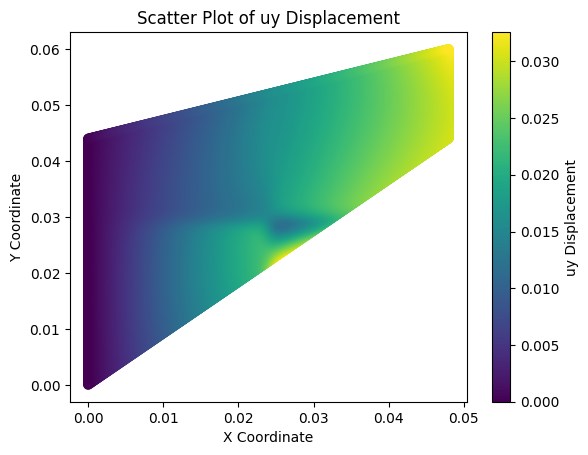

In [17]:
import matplotlib.pyplot as plt
import numpy as np
x_coords = x_batch[:, 0]
y_coords = x_batch[:, 1]

plt.scatter(x_coords, y_coords, c=uy, cmap='viridis')  

plt.colorbar(label='uy Displacement')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of uy Displacement')

plt.show()

Pinn Trainer

In [18]:
run = f"PINN_{tag}_{problem.__name__}_{network.__name__}_{nc}-nCol_{epochs}-epochs_{h}-layers_{p}-hidden_{wo}_wo_"
run

'PINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_'

In [20]:
c = Constants(
    run=run,
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    ns=(nc,),# use 200 collocation points for training
    n_test=(50,50),# use 500 points for testing
    n_steps=epochs,# number of training steps
    clear_output=True,
    show_figures=False,
    test_freq=100000,
    skip_plot_at_first=True,
)

In [21]:
from fbpinns.trainers import PINNTrainer

c["network_init_kwargs"] = dict(layer_sizes=[2,128,5]) # use a larger neural network
PINNrun = PINNTrainer(c)
PINNrun.train()

[INFO] 2024-03-25 20:55:07 - <fbpinns.constants.Constants object at 0x000001C8C0E7FDD0>
run: PINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_
domain: <class '__main__.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class '__main__.CooksProblemForward'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 150, 'nbc_points_top': 150, 'nbc_points_bottom': 150, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.   , 0.048]), array([0.  , 0.06])], 'subdomain_ws': [array([0.0576, 0.0576]), array([0.072, 0.072])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [2, 128, 5]}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.LineSchedulerRectangularND'>
scheduler_kwargs

{'static': {'domain': {'xd': 2,
   'corners': Array([[0.   , 0.   ],
          [0.   , 0.044],
          [0.048, 0.06 ],
          [0.048, 0.044]], dtype=float32)},
  'problem': {'dims': (5, 2),
   'E': Array([[[[14.,  0.],
            [ 0.,  4.]],
   
           [[ 0.,  5.],
            [ 5.,  0.]]],
   
   
          [[[ 0.,  5.],
            [ 5.,  0.]],
   
           [[ 4.,  0.],
            [ 0., 14.]]]], dtype=float32),
   'nbc_points_right': 150,
   'nbc_points_top': 150,
   'nbc_points_bottom': 150,
   'sd': 0.1}},
 'trainable': {'network': {'subdomain': {'layers': [(Array([[ 0.402205  , -0.37382653],
             [ 0.4351116 ,  0.4021373 ],
             [ 0.617773  , -0.566922  ],
             [-0.43128282,  0.0940284 ],
             [ 0.59195626,  0.55637515],
             [-0.57879406, -0.23672818],
             [ 0.26826128,  0.48355296],
             [-0.21214887,  0.00630926],
             [ 0.27483767, -0.42340106],
             [ 0.29827565,  0.54694515],
             

[INFO] 2024-03-25 21:04:28 - Loading model from:
results/models/PINN_CooksMembrane_CooksProblemForward_FCN_(50, 40)-nCol_20000-epochs_1-layers_16-hidden_1.2_wo_/model_00020000.jax
[INFO] 2024-03-25 21:04:28 - x_batch
[INFO] 2024-03-25 21:04:28 - (250000, 2), float32, ArrayImpl


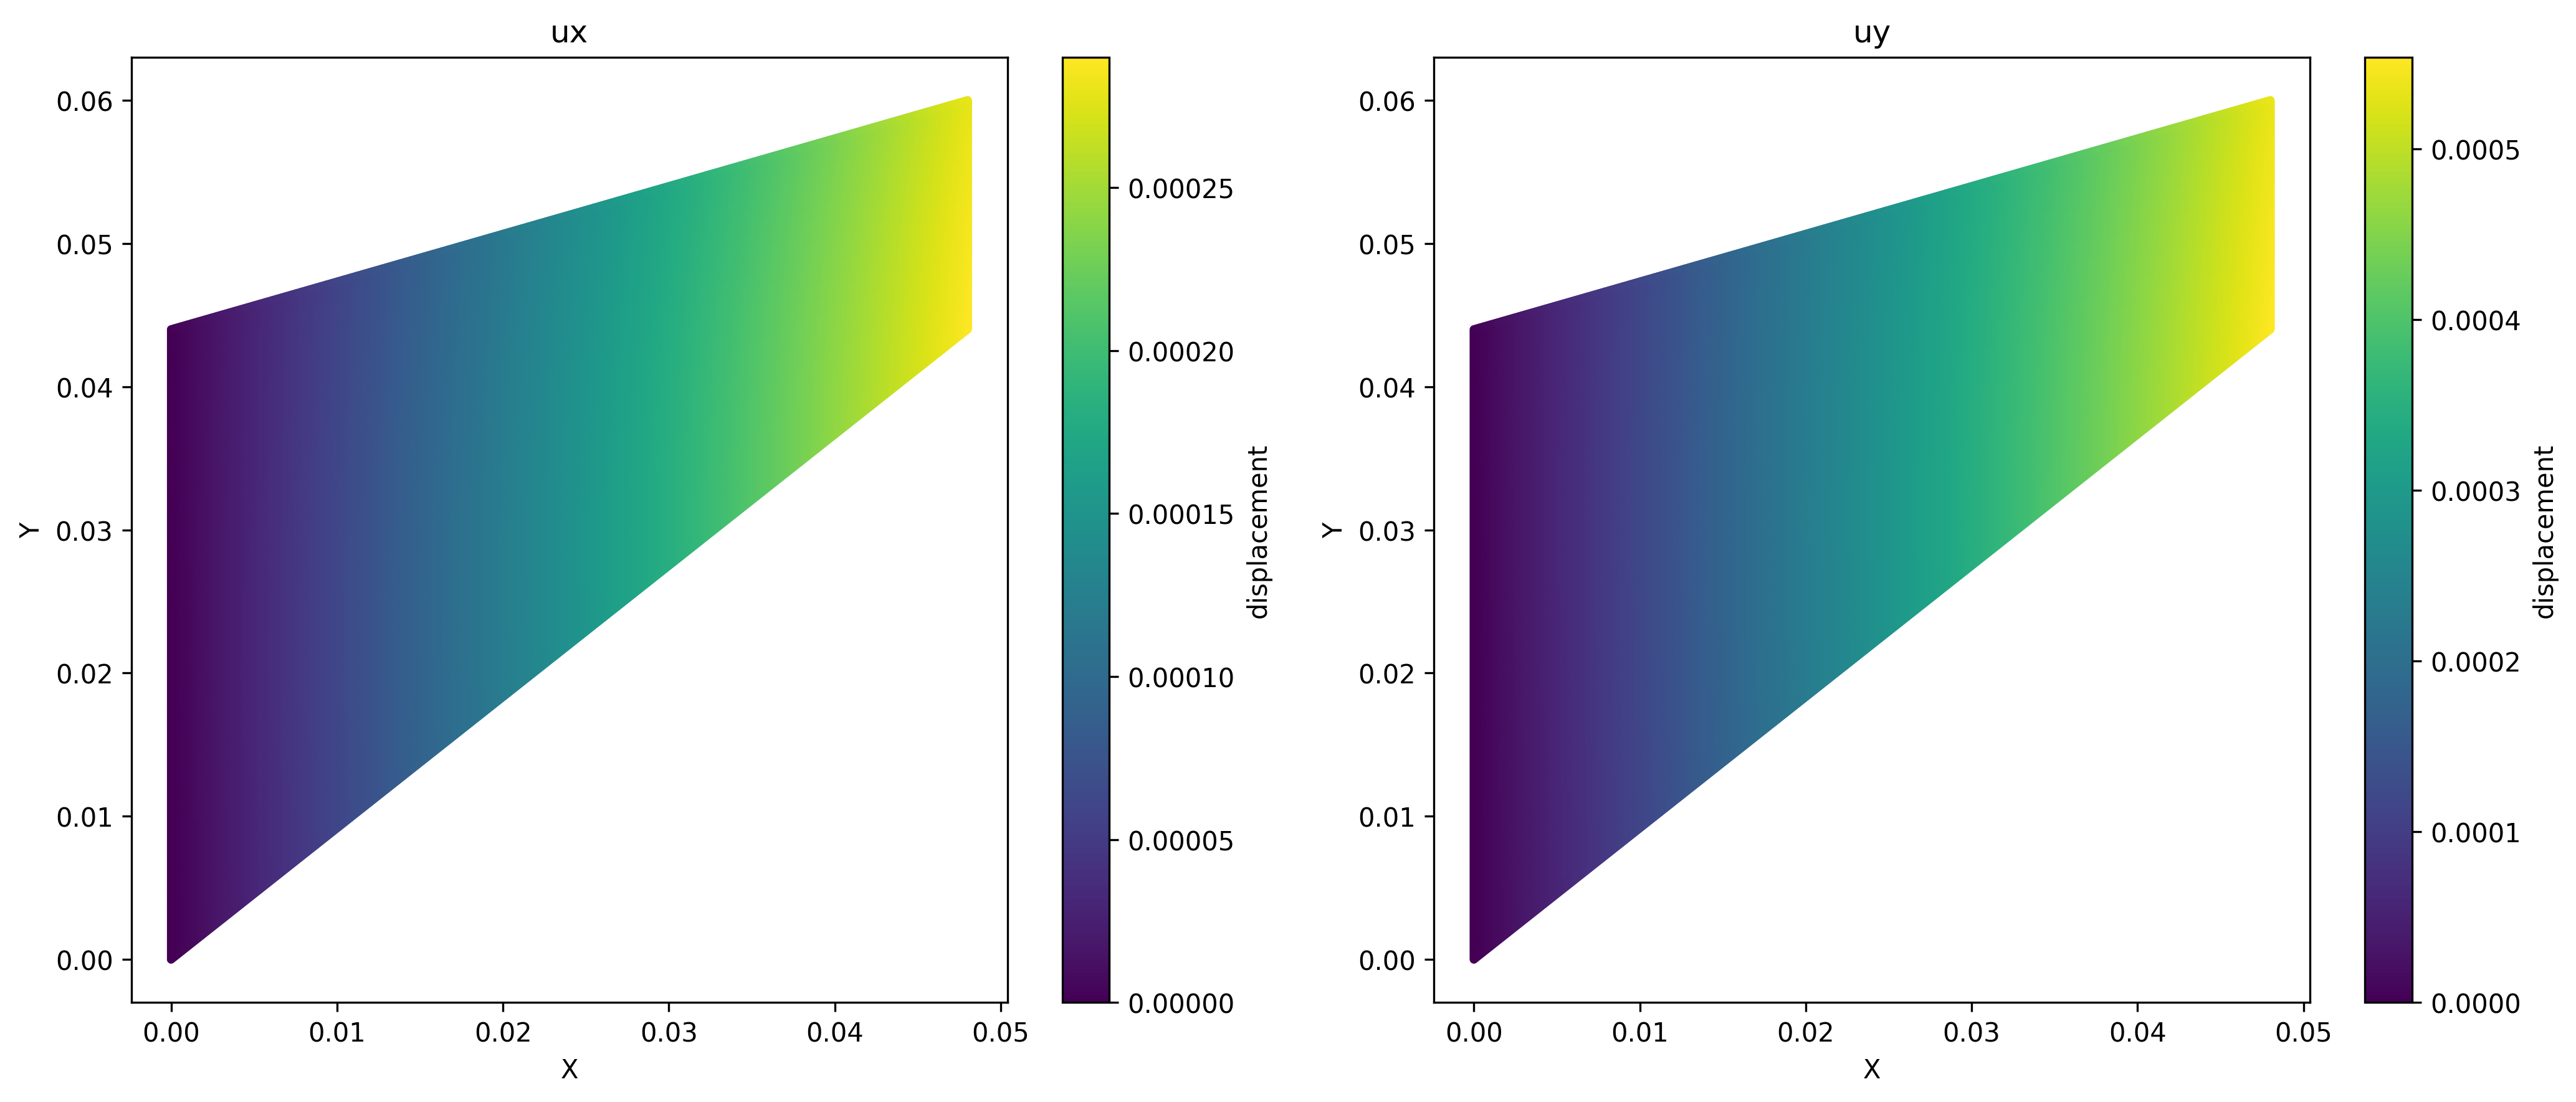

In [24]:
c, model = load_model(run, rootdir="results/")

# i, all_params, all_opt_states, u_test_losses = model
# i,t,l1n = model[-1][:,0], model[-1][:,3], model[-1][:,-1]
all_params, domain = model[1], c.domain
x_batch = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(500,500))
out = PINN_solution(c, all_params, x_batch)


ux, uy, sigaxx, sigmayy, sigmaxy  = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4],out[:,4:5]

from CooksMembrane.util import plot_deformation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation(ux, x_batch,ax1,"ux")
plot_deformation(uy, x_batch,ax2,"uy")
plt.tight_layout()
plt.show()